This first example of the basic usage of the Pyriod package was demonstrated at the [TASC5/KASC12 workshop](https://web.mit.edu/tasc5/) in Boston 22-26 July 2019.  It shows how to reproduce the frequency analysis of a pulsating helium-atmosphere white dwarf presented in [Bell et al. (A&A, 632, A42)](https://ui.adsabs.harvard.edu/abs/2019A%26A...632A..42B).  

See the online [tutorial](https://pyriod.readthedocs.io/en/latest/tutorial/) for more info about how to use Pyriod.

Pyriod installation tips:

```
# based on README.md, with following
# - only works with jupyter classic "notebook<7"
# - some qgrid codes only work with "ipywidgets<8"
mamba install "ipywidgets<8" "notebook<7" ipympl eshard::qgrid
pip install Pyriod

jupyter nbextension enable --py --sys-prefix qgrid
jupyter nbextension enable --py --sys-prefix widgetsnbextension
jupyter nbextension enable --py --sys-prefix ipympl
```

# Reproduce astroseismology result of TIC 257005016 / 8 Umi

https://ui.adsabs.harvard.edu/abs/2023Natur.618..917H/abstract

Figure 2 of the paper:

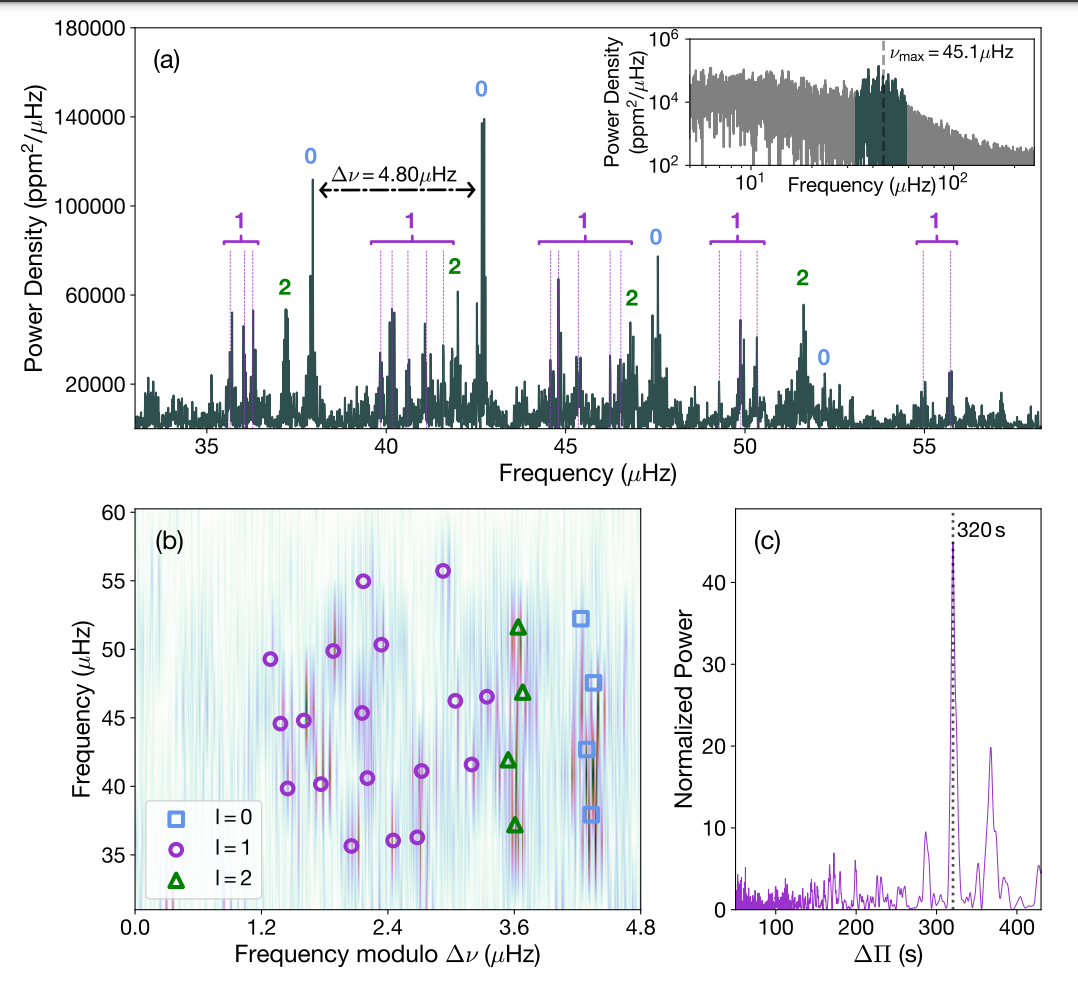

Figure 2. Identification of the evolutionary state of host star 8 UMi as a core helium-burning red giant. 

(a) Oscillation power spectrum of 8 UMi, as observed by TESS. Oscillation modes are labelled by their angular degree l. The inset presents a zoomed out view of the spectrum. 

(b) The frequency échelle diagram of the spectrum. The symbols indicate the labelled
oscillation modes. 

(c) Fourier transform of the stretched period spectrum for the l = 1 modes (see Methods). The asymptotic
l = 1 period spacing value for 8 UMi corresponds to the value of ∆Π with the largest power, which is 320s.


In [1]:
%matplotlib inline

import astropy
from astropy import units as u
from matplotlib import pyplot as plt
import numpy as np

import lightkurve as lk
from Pyriod import Pyriod


from IPython.display import display, HTML

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt


lk_download_dir = r"..\data"
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

In [2]:
#Download light curve of a DBV white dwarf pulsator observed by TESS
#Then smooth and remove outliers

sr = lk.search_lightcurve('TIC257005016',mission='TESS', sector=None,)
sr = lke.filter_by_priority(sr, author_priority=["SPOC", "TESS-SPOC", "QLP"])
sr = sr[sr.table["sequence_number"] <= 53]  # data cutoff for the paper is ~Jun 2022
display(sr)

lcc = sr.download_all()

lc = lke.stitch(lcc)
lcc

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 14,2019,SPOC,120,257005016,0.0,G022053
1,TESS Sector 15,2019,SPOC,120,257005016,0.0,G022053
2,TESS Sector 20,2019,SPOC,120,257005016,0.0,G022053
3,TESS Sector 21,2020,SPOC,120,257005016,0.0,G022053
4,TESS Sector 22,2020,SPOC,120,257005016,0.0,G022053
5,TESS Sector 26,2020,SPOC,120,257005016,0.0,G022053
6,TESS Sector 40,2021,SPOC,120,257005016,0.0,G04098
7,TESS Sector 41,2021,SPOC,120,257005016,0.0,G04098
8,TESS Sector 47,2021,SPOC,120,257005016,0.0,G04098


LightCurveCollection of 12 objects:
    0: <TessLightCurve LABEL="TIC 257005016" SECTOR=14 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 257005016" SECTOR=15 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 257005016" SECTOR=20 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 257005016" SECTOR=21 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 257005016" SECTOR=22 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 257005016" SECTOR=26 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="TIC 257005016" SECTOR=40 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    7: <TessLightCurve LABEL="TIC 257005016" SECTOR=41 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    8: <TessLightCurve LABEL="TIC 257005016" SECTOR=47 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    9: <TessLightCurve LABEL="TIC 257005016" SECTOR=48 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    10: <TessLightCurve LABEL="TIC 257005016

In [3]:
# use ppm as unit and normalization psd (spectral density) to match the paper
# Note: the paper use TESS-SIP based lc for correcting systematics though.
pg = lc.normalize(unit="ppm").to_periodogram(
#     oversample_factor=50
    normalization="psd",
);

pg.show_properties();

lightkurve.Periodogram properties:
      Attribute                   Description              Units   
---------------------- --------------------------------- ----------
                nterms                                 1           
              targetid                         257005016           
          default_view                         frequency           
                 label                     TIC 257005016           
             ls_method                              fast           
frequency_at_max_power                           42.7301        uHz
             max_power                       139198.6204 ppm2 / uHz
               nyquist                          4166.687        uHz
   period_at_max_power                            0.0234    1 / uHz
             frequency                   array (390826,)        uHz
                period                   array (390826,)    1 / uHz
                 power                   array (390826,) ppm2 / uHz
             

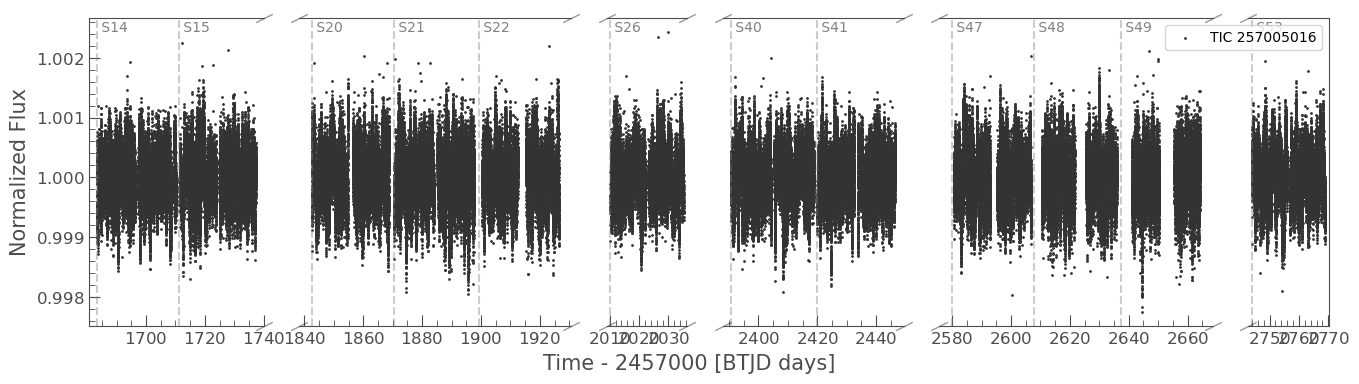

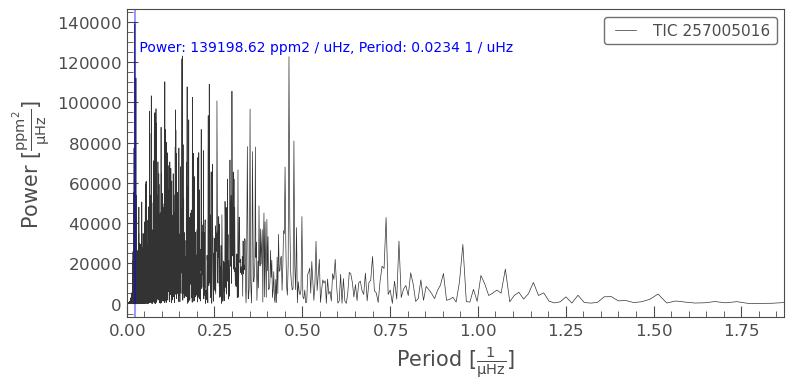

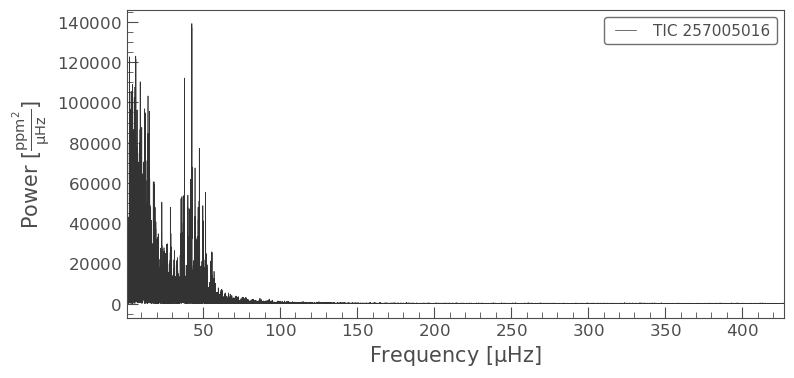

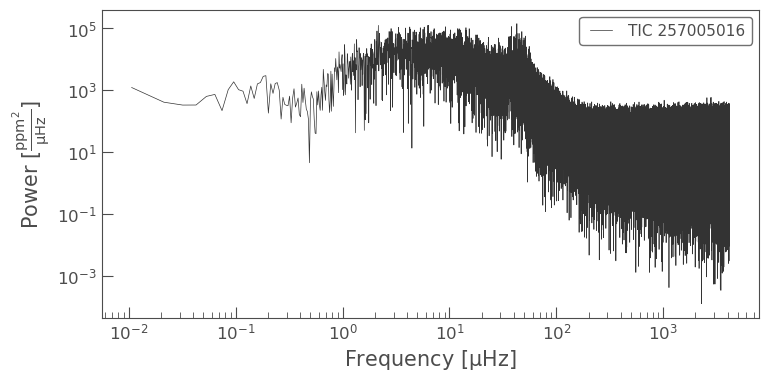

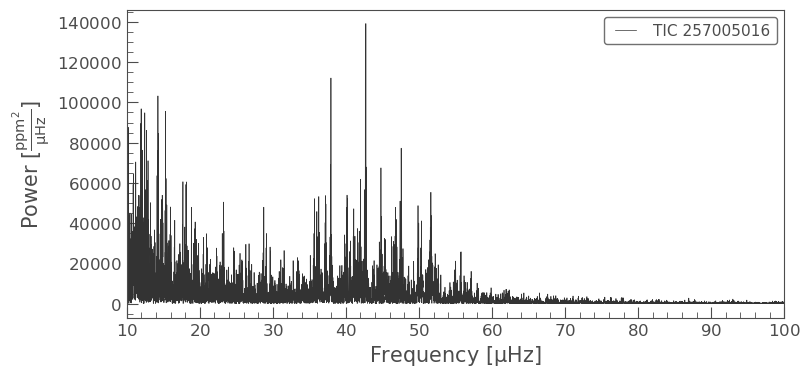

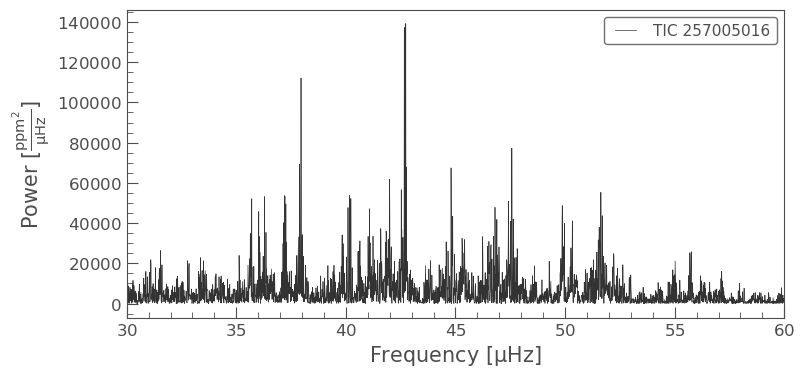

In [4]:
%matplotlib inline

axs = tplt.plot_skip_data_gap(lc);


# Overview of the pg
ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=80);

ax = pg.plot(view="frequency");  # frequency view
ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");  


# Zoom in to the section around the portion 

ax = pg.plot(view="frequency", unit=u.microhertz);
ax.set_xlim(10, 100);

ax = pg.plot(view="frequency", unit=u.microhertz);
ax.set_xlim(30, 60);


l0 spacing: [4.77622293 4.8401902  4.81886778]
l1 spacing: [0.31983636 0.33049757 3.47555508 0.33049757 0.47975454 0.43710969
 0.51173817]
l2 spacing: [4.79754535 4.80820656 4.82952899]


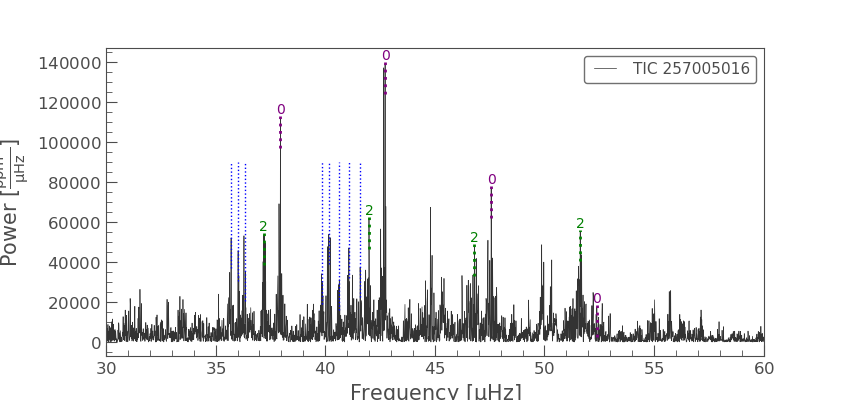

In [36]:
%matplotlib widget

l0 = np.array([
    37.953914343878075,
    42.73013727254588,
    47.57032747257977,
    52.38919524882496,  # maybe
])
print("l0 spacing:", np.diff(l0))

l1 = [
    35.704398634170694,
    36.02423499100113,
    36.35473255972591,  # or 36.29076528835982?
    
    39.830287637283284,
    40.160785206008065,
    40.64053974125372,
    41.07764942892197,
    41.58938759985067,
    # ...
    
]
print("l1 spacing:", np.diff(l1))


l2 = [
    37.196968299379385,
    41.99451365183588,  # 42.069142135096314,
    46.80272021618673,
    51.63224920432627,
]

print("l2 spacing:", np.diff(l2))

plt.close()

ax = pg.plot(view="frequency", unit=u.microhertz);
ax.set_xlim(30, 60);

l0_p = np.array([
    peaks[np.isclose(peaks["frequency"], f)][0]["power"]
    for f in l0
])
ax.vlines(l0, ymin=l0_p - 15000, ymax=l0_p + 1000,  color="purple", linestyle=":", linewidth=2, label="l0");
for f, p in zip(l0, l0_p):
    ax.text(f, p + 2000, s="0", c="purple",  horizontalalignment="center",);


    l1_p = np.array([
    peaks[np.isclose(peaks["frequency"], f)][0]["power"]
    for f in l1
])
ax.vlines(l1, ymin=l1_p - 15000, ymax=90000,  color="blue", linestyle=":", linewidth=1, label="l1");


l2_p = np.array([
    peaks[np.isclose(peaks["frequency"], f)][0]["power"]
    for f in l2
])
ax.vlines(l2, ymin=l2_p - 15000, ymax=l2_p + 1000,  color="green", linestyle=":", linewidth=2, label="l2");
for f, p in zip(l2, l2_p):
    ax.text(f, p + 2000, s="2", c="green",  horizontalalignment="center",);

In [5]:
# helper to self interactively identify the peaks
peaks = lke_pg.find_peaks(
    pg[(30 * u.microhertz <= pg.frequency ) & (pg.frequency <= 300 * u.microhertz)], 
    # powerlimit=0.0001,   
)
if "period" not in peaks.columns:
    peaks["period"] = 1 / peaks["frequency"]
    peaks["period"].unit = 1 / peaks["frequency"].unit
# if "frequency" not in peaks.columns:
#     peaks["frequency"] = 1 / peaks["period"]
#     peaks["frequency"].unit = 1 / peaks["period"].unit
# peaks["frequency_u"] = u.Quantity(peaks["frequency"]).to(u.microhertz)  # in microhertz, for log scale plot
peaks["period_h"] = u.Quantity(peaks["period"]).to(u.hour)  # period in hours
peaks["rank"] = np.linspace(1, len(peaks), len(peaks), dtype=int)


with astropy.conf.set_temp("max_lines", -1):
    display(peaks[
        (peaks["frequency"] > 41.8) & (peaks["frequency"] < 42.2)
    ][:10])

power,frequency,prominence,lower_hwhm,upper_hwhm,fwhm,frequency_ratio,period,period_h,rank
ppm2 / uHz,uHz,,uHz,uHz,uHz,,1 / uHz,h,
float64,float64,float64,float64,float64,float64,float64,float64,float64,int32
61803.988656805705,41.99451365183588,61667.43650108822,-0.0056605,+0.013531,0.019192,1.018,0.023812634390546938,6.614620664040816,7
36028.833533969715,41.83459547342066,33121.901294798976,-0.0049819,+0.015749,0.020731,1.021,0.02390366128041906,6.639905911227516,35
30347.248562822853,41.80261183773762,29070.001952043138,-0.0079086,+0.0056644,0.013573,1.022,0.023921950233196734,6.644986175887982,48
32094.773813572774,41.96253001615284,28363.87543138247,-0.017057,+0.0058729,0.022929,1.018,0.02383078426432022,6.619662295644505,51
28234.738404545136,42.069142135096314,25158.18621640361,-0.014809,+0.0052022,0.020011,1.016,0.023770392008201822,6.602886668944951,62
16944.36314447052,42.02649728751893,13652.580508539559,-0.0052479,+0.014177,0.019425,1.017,0.023794512142152304,6.609586706153418,159
22605.46942684796,41.88790153289241,13593.431789335946,-0.0055109,+0.016448,0.021959,1.020,0.023873241757282865,6.631456043689685,162
14826.398985510681,42.1544318302511,13021.325683237143,-0.0083162,+0.0071671,0.015483,1.014,0.02372229814475579,6.5895272624321635,175


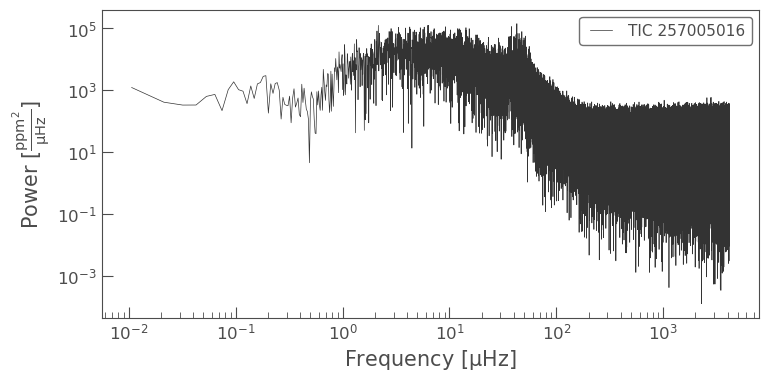

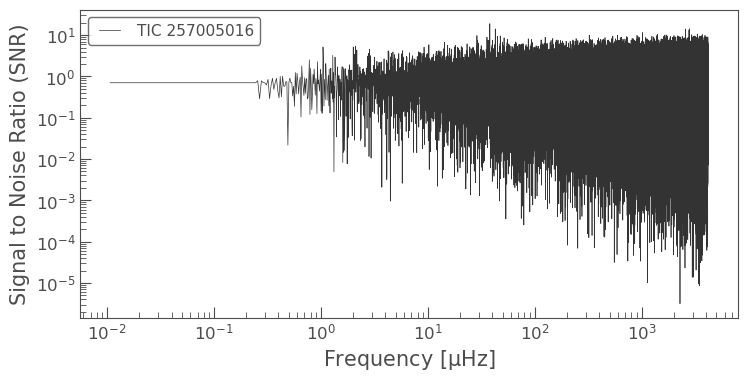

In [10]:
plt.close()

%matplotlib inline

pg_f = pg.flatten();

ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");

ax = pg_f.plot(view="frequency", unit=u.microhertz, scale="log");

In [13]:
seis = pg.to_seismology()  # unsure if it should be falttened
print("numax   est:", seis.estimate_numax())
print("deltanu est:", seis.estimate_deltanu())

numax   est: 126.0 uHz
deltanu est: 9.532763055659917 uHz


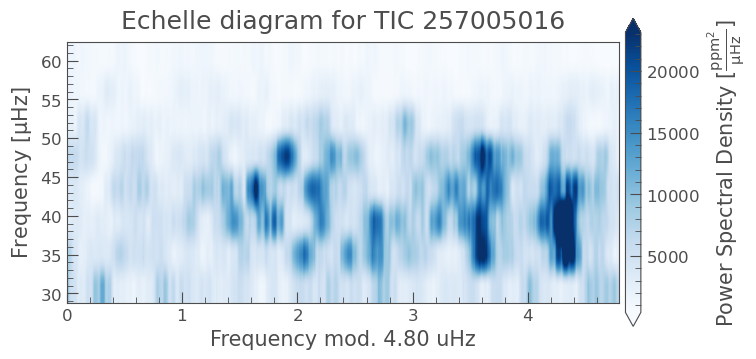

In [19]:
%matplotlib inline

plt.close();
# the 2 vertical stretch around mod 3.6uHz and 4.3uHz corresponds to l2 and l0 in the paper's figure 2
ax = seis.plot_echelle(
    deltanu=4.80,  # from the paper
    minimum_frequency=25, maximum_frequency=65,
);

In [7]:
if False:
    %matplotlib widget
    #Show all panels in single cell
    #Instantiate Pyriod object
    plt.close()
    pyriod = Pyriod(
        lc,
        freq_unit="muHz",  # "1/d"
        amp_unit="ppm",
    #     normalization="psd",  # <-- does not work for Pyriod
    #     oversample_factor=50,
    )
    # pyriod.Pyriod()